# Power Analysis

In this notebook we use the simulation method described in [Blaise et al.](https://pubmed.ncbi.nlm.nih.gov/27116637/) to perform power and study design calculations for the statistical analysis methods shown in the other notebooks.

This notebook contains simulation routines for power and sample size calculation for the following types of analyses:

**Mass univariate analysis as shown in the "Univariate Analysis" notebook:** Estimate the power to identify all variables whose mean is different between controls and cases, conditional on sample size, effect size, $\alpha$, class size imbalance and multiple testing correction method employed.

**PLS-DA models**: Determine how sample size, effect size, ammount of variables affected (size of the metabolic signature) and class imbalance affect the classification performance for a PLS-DA model.

## Code import

Import all the packages and configure notebook plotting mode.

In [1]:
# Import the required python packages including 
# the custom Chemometric Model objects
import numpy as np
import pandas as pds
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import DataConversionWarning

# Use to obtain same values as in the text
np.random.seed(350)

In [2]:
# Set the data conversion warnings to appear only once to avoid repetition during CV
warnings.filterwarnings("ignore", category=DataConversionWarning)

The next cell sets up the figure display mode. The *notebook* mode allows interactive plotting.

In [3]:
# Set the plot backend to support interactive plotting
%matplotlib notebook

## Data import

We will now import the NMR data and the metadata (Y variables).

X - NMR data matrix

Y - Matrix with the 2 metadata outcomes

ppm - Chemical shift axis for the NMR data in H $\delta$ppm.

#### Metadata
Y1 - represents the genotype (1: wild-type, 2: *sod-2* mutants, in original Y data matrix)

Y2 - represents the age (1: younger L2 worms, 2: L4 worms, in original Y data matrix)

In [4]:
# Load the dataset
X = np.genfromtxt("./data/X_spectra.csv", delimiter=',', dtype=None)
Y = pds.read_csv("./data/worm_yvars.csv",delimiter=',',dtype=None, header=None)
ppm = np.loadtxt("./data/ppm.csv",delimiter=',')

# Use pandas Categorical type to generate the dummy enconding of the Y vector (0 and 1) 
Y1 = pds.Categorical(Y.iloc[:, 0]).codes
Y2 = pds.Categorical(Y.iloc[:, 1]).codes

**Note**: To apply the analyses exemplified in this notebook to any other dataset, just modify the cell above to import the data matrices and vectors X and Y from any other source file.

The expected data types and formatting for **X** and **Y** are:

   **X**: Any data matrix with n rows (observations/samples) and p columns (variables/features). The matrix should be provided as a [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with 2 dimensions, and with shape = (n, p). We recommend using the *numpy* function [numpy.genfromtxt](https://numpy.org/devdocs/reference/generated/numpy.genfromtxt.html) or the *pandas* [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function to read the data from a text file. When using the *pandas.read_csv* function, extract the data matrix as a *numpy.ndarray* from the pandas.DataFrame object using the `.values` attribute. 
```
X_DataFrame = pds.read_csv("./data/X_spectra.csv")
X = X_DataFrame.values
```
   
   **Y** vectors: Each **Y** vector should be a 1-dimensional [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) object, with a number and ordering of elements matching the rows in **X**. For continuous variables, any regular *numpy.ndarray* with a data type of `int` (integers only) or `float` can be used.
   ```
   Y_continuous = numpy.ndarray([23.4, 24, 0.3, -1.23], dtype='float')
   ```
To encode binary class labels, a *numpy.ndarray* of dtype `int`, with 0 and 1 as labels (e.g., 0 = Control, 1 = Case) must be used. The way in which classes are encoded will affect the model interpretation: the class labeled as 1 is used as the "positive/case" class by the *pyChemometrics* objects.
   
   In the example above, we used the *pandas* [Categorical](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) datatype to handle the conversion of the original numerical values (1, 2) to the required (0, 1) labels. After converting a column to a `Categorical` datatype, the `.codes` attribute returns a vector with the same length of the original Y, but where each value is replaced by their integer (`int`) code. The correspondence between code and category can be inspected with the `categories` attribute. The order of the labels in `.codes` is the same as the order of the `categories` attribute (i.e. 0 is the first element in `categories`, 1 the second and so on).
   ```
   Y1 = pds.Categorical(Y.iloc[:, 1])
   Y1.codes # The numerical label
   Y1.categories # Original text or numerical description of the category
   ```
   [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) is another helpful function to perform dummy (0-1) encoding of variables. 

Plot all the spectra in the dataset.


<IPython.core.display.Javascript object>


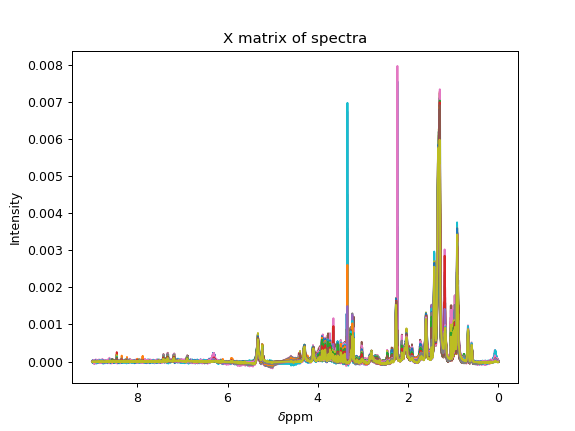

In [5]:
# Plot the spectra in the dataset
plt.figure()
plt.plot(ppm, X.T)
plt.title("X matrix of spectra")
plt.xlabel("$\delta$ppm")
plt.gca().invert_xaxis()
plt.ylabel("Intensity")
plt.show()

# Power Analysis

## 1) Univariate analysis

In the next cells, an implementation of the simulation-based method described in [Blaise et al.](https://pubmed.ncbi.nlm.nih.gov/27116637/) is used to perform power calculations and sample size determination for a 2-group case-control study design, analysed with the univariate analysis scheme shown in the "Univariate Analysis" notebook. Power calculations are helpful to benchmark and explore the limitations of the study design and data analysis strategy used, and assist in the planing of a validation study. 

The method used here for power calculations in a mass univariate analysis setting contains the following steps:

 **1) Estimate a generative model for the metabolic profile data:** A log-normal distribution is fitted to each variable, and the empirical covariance matrix estimated from the data. These can be used to generate an arbitrary number of simulated "fake" samples, with distributional characteristics and correlation structure similar to the original data.
 
 **2) Introduce an artificial difference between cases and controls:** Using the generative model fitted in step 1, generate a series of artificial samples and randomly assign them to the case or control groups. To simulate class imbalance, `class_balance=` can be set to any value between 0 and 1 .  Then, introduce a difference between the two groups by adding the the case group a value with a magnitude set by the user in the `effect_sizes=` argument. The effect size magnitude is parametrized using the *Cohen's d* measure $d = \frac{\mu_{cases} - \mu_{controls}}{\sigma_{pooled}}$. 
 
If `modification_scheme` is "correlation" and the row/column from the corresponding variables to be modified are passed to `weight_vector=`, all variables with a correlation absolute value higher than `weight_threshold` are modified as well. This option can be used to more realistically represent the expected patterns of change for a metabolic profiling dataset (e.g., all high resolution points corresponding to an NMR resonance are changed together). 
 
 **3) Analyse the data using the statistical analysis and score the results:** Apply the statistical analysis procedure to be benchmarked (in this case, a one-way ANOVA test, which in this context is equivalent to the regression model used in the "Univariate Analysis" notebook) and estimate the differences between case and control and the corresponding one-way ANOVA *p-values*. The ANOVA test is applied to all variables in the metabolic matrix. The obtained *p-values* or *q-values* and the selected $\alpha$ rejection cut-off are used to score variables as "hits", if p-value or q-value < $\alpha$, or otherwise "non-hits". Together with the information of which variables were modified in step 2, the results are assigned as true positives (TP), false positives (FP), true negatives (TN) or false negatives (FN). The TP/FP/TN/FN counts are then used to estimate a series of metrics, such as the True Positive Rate (= statistical power) or False Discovery Rate.
 
 **4) Repeat the process multiple times and average results over all iterations:** The previous steps are repeated multiple times (set by the `n_repeats=` parameter; higher values improve the precision of the estimates) and the results averaged accross the repeats to obtain monte-carlo estimates for power and all other metrics estimated in step 3.

In [6]:
from power_analysis.power_analysis import power_analysis

/home/gd2212/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/gd2212/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cross_decomposition.pls_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cross_decomposition. Anything that cannot be imported from sklearn.cross_decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
#load the results of the univariate testing procedure
univ_gen = pds.read_csv('./data/UnivariateAnalysis_Genotype.csv')

# Select significant peaks from univariate analysis 
signif = np.where(univ_gen['genotype_q-value'] < 0.05)[0]

# Get the total size of the metabolic signature uncovered
univ_signature_size = len(signif)
# Select only the samples with genotype = wild-type
X_controls = X[Y1 == 1, :]

To perform power calculations, use the *power_analysis* function. This function requires a "pilot" study data matrix (we will use the data from the wild-type in this example).

List of arguments for the *power_analysis*:

`data`: Data matrix to use. (e.g. the data matrix from the pilot study).

`effect_size`: List of effect sizes to test.

`sample_size`: List of sample sizes to test.

`class_balance`: Proportion of cases in the entire dataset, use to model class imbalance.

`n_repeats`: Number of times to repeat the simulation. Higher number of repeats improve the precision of the estimates, but can significantly increase the run-time of the simulations. 

`alpha`: Significance level $\alpha$ used to reject null-hypotheses when applicable.

`variables_to_calculate`: `list` or `numpy.ndarray` containing the set of variables to modify. If None (default), the simulation is performed for all variables individually in the data.

`fakedata_size`: Number of artificial samples to simulate. If any sample size is larger than this value, `fakedata_size` will be automatically adjusted.

`model`: Type of method to benchmark. Either "ANOVA" (default) or "PLS-DA".

`weight_vector`: Vector to weight results and select which high. The row(s) or column(s) of the correlation matrix corresponding to the variables in `variables_to_calculate` should be passed. Can be a 1-d or 2-d `numpy.ndarray`.

`modification_type`: Type of modification to perform. Default is "correlation", where all variables with an absolute value higher than `weight_threshold` will be also modified together with the values passed to `variables_to_calculate`. If no value is passed to `weight_vector`, only the variables specified directly are modified.

If `modification_type="correlation_weighted"` is chosen, the variable modification occurs as in the correlation case, but the scoring of true and false positives and negatives is weighted by the `weight_vector` values (i.e., a true positive for a variable passed in `variables_to_calculate` has a higher score than a correlated variable selected with the `weight_threshold` argument).

`weight_threshold`: Threshold to apply to `weight_vector` to decide wether or not a variable should be modified or not. For example, to ignore correlated variables and simply modify one variable at the time, use `modification_type='correlation'` and `weight_threshold=1`

The *power_analysis* routine can be used in multiple ways. In the next cell, we use it to examine the power achieved over multiple effect and sample sizes combinations for a a single pre-specified variable. 

In [ ]:
# get the variable index corresponding to ppm = 2.0725
which_var = np.array(np.where(ppm == 2.0725)[0])

power_simulation_1Var = power_analysis(X_controls, effect_size=np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
                      sample_size=np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 2000]), alpha=0.05, model='ANOVA',
                      simmodel='lognormal', fakedata_size=1000, n_repeats=20,
                      variables_to_calculate=which_var)

In [8]:
# Import plotting functions
from power_analysis.plotting import plot_metric_heatmap, plot_metric_spectrum

Use the *plot_metric_heatmap* to visualize the performance estimates for a given variable or "signature" (set of variables modified in tandem).

The first argument passed to *plot_metric_heatmap* should be an output of the *power_analysis* function. 
`which_var` specifies the index of the variable/signature to plot.

The following metrics are automatically calculated by the *power_analysis* function:

    "True Positive Rate" (same as power, recall or sensitivity)
    "False Positive Rate" 
    "True Negative Rate" (same as specificity)
    "False Negative Rate"
    "False Discovery Rate"
    "Positive Predictive Value" (same as precision)
    "Negative Predictive Value"
    "False Omission Rate"
    "Accuracy"
    "F1" (F1 score)
    
The default value for `metric` is the "True Positive Rate". If `plot_multiple_testing=True`, the multiple testing adjusted results are plotted, otherwise (`=False`, the default value) the metric value plotted is the one estimated from the raw unadjusted results.

The `interpolation` argument is passed directly to the `matplotlib.pyplot.imshow` function. For a list of accepted arguments see [matplotlib.pyplot.imshow](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html)

The contour line marks the regions where power = 0.8 (can be modified with the `contour_level` argument). 

Inspection of the plot shows that sample sizes above < 150 only achieve power levels above 80% for effect sizes greater than 0.5. Small effect sizes (< 0.2) require a very large sample size (> 2000) to reach power = 80%

In [ ]:
plot_metric_heatmap(power_simulation_1Var, which_var=0, 
                    interpolation='bicubic', metric="True Positive Rate", contour_level=0.8, 
                    plot_multiple_testing=False)

If `plot_multiple_testing=True` the metrics estimated from the multiple testing adjusted values are plotted instead. The Benjamini-Yekutieli FDR-correction method is particularly stringent, and severily reduces statistical power. Effect sizes below 0.5 now require sample sizes > 500 to be reliably detected.

In [ ]:
plot_metric_heatmap(power_simulation_1Var, which_var=0, plot_multiple_testing=True, 
                    metric='True Positive Rate', interpolation='bicubic')

The `variables_to_calculate` argument can also accept a 2D array (i.e., np.array([[2,43,5]. [2,356, 247]])), where each row contains integers represeting the column index of variables to test.

In this case, all of the variables in each row of the array will be modified together. This option is usefull to assess the power to detect changes in entire signatures as oposed to a single variable only. In the cell below we apply this functionality to perform power calculations for the detection of the entire signature uncovered in the "Univariate Analysis" notebook.

In [ ]:
power_simulation_univariate_signature = power_analysis(X_controls, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5]),
                      np.array([50, 100, 150, 200, 300, 400, 500]), alpha=0.05, model='ANOVA',
                      simmodel='lognormal', fakedata_size=1000, n_repeats=50,
                      variables_to_calculate=np.array([signif]))

In [ ]:
plot_metric_heatmap(power_simulation_univariate_signature, which_var=0, 
                    plot_multiple_testing=False, metric='True Positive Rate', 
                    interpolation='bicubic')

Setting `variables_to_calculate` to None will evaluate all of the variables. 

**Note**: The run-time of the simulation depends on the combination of number of variables, sample sizes, effect sizes and number of repeats. Running can take more than 2h on datasets with large number of variables (> 5000). 

In [ ]:
power_simulation_whole_set = power_analysis(X_controls, np.array([0.35]),
                      np.array([350]), alpha=0.05, model='ANOVA',
                      simmodel='lognormal', fakedata_size=1000, n_repeats=15,
                      variables_to_calculate=None)

The *plot_metric_spectrum* plots the levels of power or over metric over a representative spectrum.

In [ ]:
plot_metric_spectrum(power_simulation_whole_set , ref_spectrum=np.median(X_controls, axis=0), xvar=ppm, plot_multiple_testing=False)

**Note:** When using pre-existing datasets and their analysis results to infer power and sample size calculations, it is recommended to explore a wide range of effect sizes different from the ones found in the original analysis. Small sample sizes can lead to detection of inflated effect sizes in statistical analysis, and a post-hoc power analysis assuming these effect sizes to be genuine will give optimistic power and sample size estimates.

## 2) PLS-DA

The simulation scheme used in the next cells to perform design calculations for a PLS-DA analysis of a 2-group case-control design is similar to the one used in the univariate case:

 **1) Estimate a generative model for the metabolic profile data:** This step is performed in the same manner as in the univariate case.
 
 **2) Introduce an artificial difference between cases and controls:** The effect size modification is also parametrized using the *Cohen's d* measure. However, to benchmark a PLS-DA model, the modifications are repeated for a training and and independent test sets.

 **3) Analyse the data using the statistical analysis and score the results:** The PLS-DA model is fitted using only data from the training set. It is then used to classify the samples on the test set. The performance metrics for the PLS-DA simulation are calculated based on the test set samples classification results, and not on retrieval of modified variables. 
 
 **4) Repeat the process multiple times and average results over all iterations:** Same as in the univariate case.
 
The main difference is that the results are scored based on the sample classification performance (quality of the prediction) and not on the retrieval of the modified variables. All options and variable modification schemes shown for the univariate case apply (one variable at a time, signature modification, *etc*).

The following arguments are specific to a PLS-DA model, and should be passed using Python's \*\**kwargs* synthax:
    
`n_components_criteria`: If 'fixed', fit PLS-DA models with a set number of components. If 'scree' find the best component using cross-validatin and the Q2Y metric, as shown in the "Multivariate Analysis - Supervised Analysis with PLS-DA" notebook.

`n_components`: Number of PLS components to use. If `n_components_criteria` is 'scree' this value is interpreted as the maximum number of components to try for each model during the parameter selection.

`test_set_proportion`: Proportion of samples in the test set compared to the training set. By default it is set to 1 (test and training set sample sizes are identical).

In [9]:
power_simulation_pls_da_signature = power_analysis(X_controls, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5]),
                      np.array([50, 100, 150, 200, 300, 400, 500, 2000]), model='PLS-DA',
                      simmodel='lognormal', fakedata_size=1000, n_repeats=10,
                      variables_to_calculate=np.array([signif]), **{'n_components':5, 
                                                                    'n_components_criteria':'fixed'})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 10.9min finished


<IPython.core.display.Javascript object>


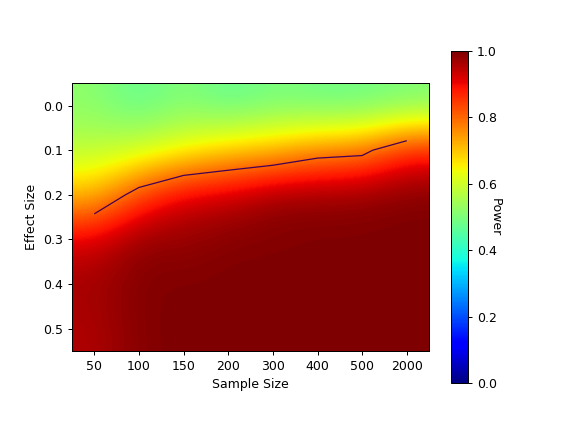

In [31]:
plot_metric_heatmap(power_simulation_pls_da_signature, which_var=0, plot_multiple_testing=False, 
                    metric='True Positive Rate', interpolation='bicubic')

For a PLS-DA multivariate model, the proportion of variables modified (size of the signature) also affects the performance of the method and its capacity to pick up the biological effect. Contrast the results below with the validation of the signature above. For similar effect and sample size combinations, with the same number of components, the power achieve is reduced when the size of the signature is smaller (p=5 variables).

**Note**: In the PLS-DA simulations the metrics are calculated using the sample classification. Since a random classifier has a 50% chance of  picking the correct class on an balanced dataset, the lower expected null level for True Positive Rate/Power/Recall is 0.5 and not 0 as in the univariate case.

In [34]:
# Randomly pick 50 variable, and pass them as a single signature.
random_vars = np.array([np.random.choice(range(8600), 5, replace=False)])

power_simulation_pls_da_small_signature = power_analysis(X_controls, np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5]),
                      np.array([50, 100, 150, 200, 300, 400, 500, 2000]), model='PLS-DA',
                      simmodel='lognormal', fakedata_size=1000, n_repeats=10,
                      variables_to_calculate=random_vars, **{'n_components':5, 'n_components_criteria':'fixed'})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 10.1min finished


<IPython.core.display.Javascript object>


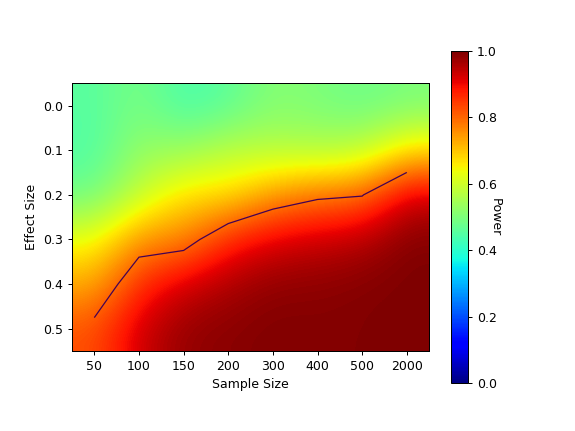

In [36]:
plot_metric_heatmap(power_simulation_pls_da_small_signature, which_var=0, plot_multiple_testing=False, 
                    metric='True Positive Rate')

We recommend using the PLS-DA sample size determination model to design biomarker validation studies, where the predictive capacity of the biomarker signature is the main aspect to validate.